## UNT MODELS for DARPA Hurdle 3 

Given that a Random Guess does not perform well enough to pass the 3rd hurdle of the DARPA Sharing Spectrum Competition, Then a more intelligent solution is required. In this document I propose 3 posible solutions for this 3rd hurdle. 




#### Solution 1: Generic Random Forest Predictor given the past behaviour

   This is the fastest and one of the easiest methods I could think of. Given the last outputs of the Player and the DARPA player let a Random Forest predict the next output given a sequence of previous outputs. 
   
   Input sequences may be M-length or Fixed-Length (e.g. 100 samples) 
     
   Output of the estimator is a M-length-1 vector with the probabilities of each posible output. From here we select the most Probable output as our prediction and the Least probable output as out selection 
   


In [73]:
# import UNT_hurdle3.py  for training and simulation 

import UNT_hurdle3 as h3 
import pandas as pd 
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np
import itertools


class RFPlayer:
    ''' A Simple class that simulate a RandomForest base Player for the #3 Hurdle of the DARPA Competition  '''
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier                       
        
        
        
    def __init__ (self, N,retrain=500, seq_size = 100):
        self._type = "RF"
        self.N = N                        ## Random N-states (NOT USED)
        self.M = N                        ##  M-outputs
        self.clf = RandomForestClassifier(n_estimators=25) ## Our estimator
        self.retrain = retrain            ## Retrain after #retrain turns of the game
        self.input_size = seq_size        ## How many lags should we include
        self.Dataset = self.createDataset(seq_size)
        self.record = pd.DataFrame( columns=['Player_Last','Last','pred'])
        self.feature = []
        self.turn = 0
        self.LastPred = -1
                            
        
        # In order to get A -> choice from Q column
    def start(self):

        D,P = [np.random.choice(range(1,self.M)),np.random.choice(range(1,self.M))]
        self.Prev_D = D
        return D,P
        
    def step(self, A):
        
        self.turn = self.turn +1
        self.appendData(A,self.Prev_D, self.LastPred)
        
        if self.turn < self.retrain:
            D,P = self.start()
                    
        else:
            # check if is time to train 
            if self.turn%self.retrain == 0:
                # Train
                self.Train()
                    
            D,P = self.predict()            
                 
        self.Prev_D = D
        self.LastPred = P
        return [D,P]
    
    
    def createDataset(self, lags):
        Player_names = ['Player_lag_{0} '.format(s) for s in range(1,lags)]
        Bot_names = ["Bot_lag_{0}".format(s) for s in range(1,lags)]
        cols = np.concatenate([['Player_Last','Last'],Player_names,Bot_names], axis=0)
        
                                           
        df = pd.DataFrame(columns=['Player_Last','Last'], dtype = 'int32')
        
        return df        
    
    def FormatData(self):
        
        tdf = pd.concat([self.record.Player_Last.shift(n) for n in range(1,self.input_size)], axis=1)
        tdf.columns = ['Player_lag_{0} '.format(s) for s in range(1,self.input_size)]
        ttdf = pd.concat([self.record.Last.shift(n) for n in range(1,self.input_size) ], axis=1)
        ttdf.columns = ['Bot_lag_{0} '.format(s) for s in range(1,self.input_size)]

        df = pd.concat([self.record,tdf,ttdf], axis=1)
        
        return df
    
    def appendData(self, A, D,P):
                
        self.record = self.record.append(pd.DataFrame([[D,A,P]], columns=['Player_Last','Last','pred']),ignore_index=True)
        self.Dataset = self.FormatData()
        
    def Train(self):                
        
        print "Training.. "
        df = self.Dataset.drop('pred',1).copy()
        df['Label'] = self.Dataset.Last.shift(-1)  
        df = df.dropna(axis=0) # Remove NA rows 
        rf = RandomForestClassifier(n_estimators=20) # Basic Clf
        
        #run grid search
        kf = KFold(df.shape[0],n_folds=3)
        grid_search = GridSearchCV(rf,{})  
        
        
        x = df.drop('Label',1)
        y = df.Label
        self.clf = grid_search.fit(x,y)            
        
        #print "Train ACC:", accuracy_score(y, self.clf.predict(x))
        return True    

    
    def predict(self):
        proba = self.clf.predict_proba(self.Dataset.drop('pred',1)[-1:])
        
        l = self.Dataset.Last.unique()
        l.sort(axis=0)
        

        
        return l[proba.argmin()], l[proba.argmax()] # P = More Likely, D = Less Likely 
        
    def restart(self):
        print "Restarting.. "
        self.__init__(self.N,self.retrain,self.input_size)
        return True
        
        
class JorgePlayer:
    ''' 
    A Simple class that simulate a base Player based on Jorge's prediction
    for the #3 Hurdle of the DARPA Competition
    '''
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier 
    import itertools
   
    def __init__ (self, N,retrain=500):
        
        self._type = "Jorge"
        self.N = N                        ## Random N-states (NOT USED)
        self.M = N                        ##  M-outputs        
        self.retrain = retrain            ## Retrain after #retrain turns of the game        
        self.Dataset, self.BestPlayTable = self.createDataset()
        self.record = pd.DataFrame( columns=['Player_Last','Last','pred','Player_Play'])
        
        self.turn = 0
        self.PlayerLast = -1
                                    
    def start(self):

        D,P = [np.random.choice(range(self.M)),np.random.choice(range(self.M))]
        self.Prev_D = D
        return D,P
        
    def step(self, Last):
        
        self.turn = self.turn +1
        
        if self.turn < self.retrain:
            PlayerPlay,pred = self.start()
                    
        else:
            # check if is time to train 
            if self.turn%self.retrain == 0:
                # Train
                self.Train()
                    
            PlayerPlay,pred = self.predict(Last)            
                 
        self.appendData(Last,self.PlayerLast, pred,PlayerPlay)

        self.PlayerLast = PlayerPlay
        
        return [PlayerPlay,pred]
    
    
    def updateBestPlay(self,Player_Last, Last):
        if PlayerPlay == Last:
            self.BestPlayTable[self.BestPlayTable.index == Player_Last] = self.BestPlayTable[self.BestPlayTable.index == Player_Last] -1
        else:
            self.BestPlayTable[self.BestPlayTable.index == Player_Last] = self.BestPlayTable[self.BestPlayTable.index == Player_Last] +1
            
    
    def updateDataset(self):  
        
        df= self.record
        df['Label'] = df.Last.shift(-1)
        self.Dataset =df.groupby(['Player_Play','Last']).Label.agg(lambda x:x.value_counts().index[0]).reset_index()                
        
    def createDataset(self):
        
        # Create Dataset : Counts the Number of times the oponent makes a play by a giving combination of Last and Player_Play
        
        #features = ["{0}".format(s) for s in range(self.N)]
        #features = np.concatenate([['Player_Play','Last'], features])
        #df = pd.DataFrame(columns=[features], dtype='int32')
        #for i,v in  itertools.combinations(range(self.N),2): # All Permutations
            #zeros = np.zeros(self.N+2)
            #zeros[0] = i 
            #zeros[1] = v
            #df = df.append(pd.DataFrame([zeros],columns=features), ignore_index=True)

        #for i in range(10): # All repeated values
            #zeros = np.zeros(self.N+2)
            #zeros[0] = i
            #zeros[1] = i
            #df = df.append(pd.DataFrame([zeros],columns=features), ignore_index=True)
        
        df = pd.DataFrame(columns=['Player_Play','Last','pred','Player_Last','pred'])
        #table to keep score of our best plays 
        table = pd.DataFrame(index=range(self.N), columns=['Points'])
        return df, table
    
    
    def appendData(self, Last, Player_Last,pred,Play):
                
        self.record = self.record.append(pd.DataFrame([[Last, Player_Last,pred,Play]], columns=['Last','Player_Last','pred','Player_Play']),ignore_index=True)
        
    def Train(self):                
        
        print "Training.. "
        # Training is really update the Dataset
        self.updateDataset()
        
        return True    

    
    def predict(self,Last):
        
        good = False
        for i in range(1,11):
            play = self.BestPlayTable.sort('Points')[:i].index.values[-1] # i+1
            
            pred = self.Dataset[(self.Dataset.Player_Play == play) & (self.Dataset.Last == Last)].Label.iloc[0]
            
            if play != pred:
                good = True
                break
        
        if not good:
            play,pred = np.random.randint(0,self.N,size=2)               

        
        return play,pred # P = More Likely, D = Less Likely 
        
    def restart(self):
        print "Restarting.. "
        self.__init__(self.N,self.retrain)
        return True
               
        
        

In [74]:
test = h3.DarpaPlayer(10,probs=1)
test.start()
test.step(1)
test.step(2)
test.step(3)
test.step(4)
test.step(5)

1
1


(4, 8)

In [75]:
test.transition_mat[0,0,:]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

In [76]:
for i in range(0,100):
    test.step(1)
    test.step(2)
    test.step(3)
    test.step(4)
    test.step(5)

1
Total MC Runs 3
Total Turns 3000
1
1
Restarting.. 
Training.. 


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:232: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Training.. 
1
1
Restarting.. 
Training.. 
Training.. 
1
1
Restarting.. 
Training.. 
Training.. 
CPU times: user 44.1 s, sys: 24.9 ms, total: 44.1 s
Wall time: 44.1 s


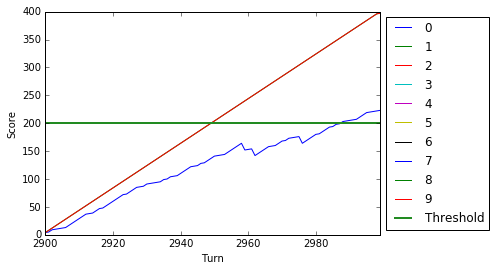

In [77]:
P1 = h3.DarpaPlayer(10,probs=1)

RFP = JorgePlayer(10,retrain=1000)

test = h3.Hurdle_MC(P1,RFP,total_turns = 3000, total_runs=3)

print "Total MC Runs", test.mc_runs
print "Total Turns", test.turns
%time test.simulate()

In [72]:
#test.PlayerA.Dataset[(test.PlayerA.Dataset.Player_Last == test.PlayerA.Dataset.Last) & (test.PlayerA.record.index  > 29000)].shape
df= test.PlayerA.Dataset
print df[(df.Player_Play == 0) & (df.Last == 3)].Label.iloc[0]
print df[(df.Player_Play == 0) & (df.Last == 3)]

0.0
   Player_Play  Last  Label    Max
3          0.0   3.0    0.0  Label


In [28]:
print test.PlayerD.transition_mat[0,0,:]
df[(df.Player_Play == 1) & (df.Last == 1)].Label.value_counts()

[ 0.04616617  0.05350465  0.17588837  0.13372383  0.11869456  0.1122892
  0.13322984  0.01488201  0.08279615  0.1288252 ]


4.0    21
Name: Label, dtype: int64

### Solution 4: HMM 



In [ ]:
play,pred = np.random.randint(0,10,size=2)

print play, pred

In [ ]:
from hmmlearn.hmm import GaussianHMM
class HMMPlayer:
    ''' A Simple class that simulate a Random Player for the #3 Hurdle of the DARPA Competition  '''
    import numpy as np
    
        
    def __init__ (self, N, retrain=500, seq_size = 100):
        self._type = "HMM"        
        self.N = N                               ##  M-outputs
        self.M = N
        self.record = pd.DataFrame( columns=['Player_Last','Last','pred'])
        self.turn = 0
        self.retrain = retrain
        self.LastPred = -1
        self.model = GaussianHMM(n_components=N, covariance_type="full", n_iter=500)

                    
    def start(self):
        
        D,P = [np.random.choice(range(1,self.M)),np.random.choice(range(1,self.M))]
        self.Prev_D = D
        return D,P
        
    def step(self, A):
        
        self.turn = self.turn +1
        self.appendData(A,self.Prev_D, self.LastPred)
        
        if self.turn < self.retrain:
            D,P = self.start()
                    
        else:
            # check if is time to train 
            if self.turn%self.retrain == 0:
                # Train
                self.Train()
                    
            D,P = self.predict()            
                 
        self.Prev_D = D
        self.LastPred = P
        return [D,P]
        
    def appendData(self, A, D,P):
                
        self.record = self.record.append(pd.DataFrame([[D,A,P]], columns=['Player_Last','Last','pred']),ignore_index=True)
        
        
    def Train(self):                
        
        print "Training.. "
        df = self.record.drop('pred',1).copy()
        df['Label'] = self.record.Last.shift(-1)  
        df = df.dropna(axis=0) # Remove NA rows 
        
        
        x = df.drop('Label',1)
        y = df.Label
        
        self.model = self.model.fit(x)
                       
        #print "Train ACC:", accuracy_score(y, self.clf.predict(x))
        return True    

    
    def predict(self):
        
        # Predict the optimal sequence of internal hidden state
        hidden_states = self.model.predict(self.record[['Player_Last', 'Last']]) ## This will give us a n_components x n_components transmition matrix that tries to imitate the DARPA Player Q matrix
        
        darpa_state = hidden_states[-1:] # this will give me the last state of the most probable 
        p_ = self.model.transmat_[darpa_state,:][0]
                
        P = np.random.choice(range(self.N), p=p_)
        
        p_x = 1-p_ # Inverse Probabilities to get the Least Likely   
        p_x[P] = 0 # Make sure we dont get the same output by randomness
        p_x = (1-p_x)/sum(1-p_x)      # Norm 
        
        D = np.random.choice(range(self.N), p= p_x)

        
        return D,P  # P = More Likely, D = Less Likely 
        
    def restart(self):
        print "Restarting.. "
        self.__init__(self.N,retrain=self.retrain)
        return True
        

In [ ]:
test = HMMPlayer(10)
test.start()
test.step(1)
test.step(2)
test.step(3)
test.step(4)
test.step(5)

In [ ]:
#P1 = h3.RandomPlayer(10,10)
HMMP = HMMPlayer(10,retrain=29000)

test = h3.Hurdle_MC(P1,HMMP,total_turns = 30000, total_runs=3)

print "Total MC Runs", test.mc_runs
print "Total Turns", test.turns
%time test.simulate()

In [ ]:
from sklearn.metrics import accuracy_score
print test.PlayerA.record[(test.PlayerA.record.Player_Last == test.PlayerA.record.Last) & (test.PlayerA.record.index  > 29000)].shape
y_test = test.PlayerA.record.Last[(test.PlayerA.record.index  > 29000)].fillna(0)
pred = test.PlayerA.record.pred[(test.PlayerA.record.index  > 29000)]
print "ACC:", accuracy_score(y_test,pred )


#### Solution 2: eXtreme Gradient Bosting Machine (XGB)  given the past behaviour

   This is an evolution of the first method, However it requires the instalation of XGB in the docker_container. Same procedure as the Solution 1 
   
   Input sequences may be M-length or Fixed-Length (e.g. 100 samples) 
     
   Output of the estimator is a M-length-1 vector with the probabilities of each posible output. From here we select the most Probable output as our prediction and the Least probable output as out selection 

#### Solution 3: Long Short Term Memory Neural Networks on Tensorflow (The good stuff!)  given the past behaviour

   This is completly different approach from the previous models. (TODO: Add more info for LSTM if needed) 
   
           
   Output of the estimator is a M-length-1 vector with the probabilities of each posible output. From here we select the most Probable output as our prediction and the Least probable output as out selection 
      

In [ ]:
print test.PlayerA.clf.predict_proba(test.PlayerA.Dataset.drop('pred',1)[-5:])
print test.PlayerA.clf.predict(test.PlayerA.Dataset.drop('pred',1)[-5:])


In [ ]:
l = test.PlayerA.Dataset.Last.unique()
l.sort(axis=0)
print l

proba = test.PlayerA.clf.predict_proba(test.PlayerA.Dataset.drop('pred',1)[-1:])
pred = test.PlayerA.clf.predict(test.PlayerA.Dataset.drop('pred',1)[-1:])

print "More Likely: ", l[proba.argmax()], " Pred: ", pred
print "Less Likely: ", l[proba.argmin()], " Pred: ", pred, " Probas: ", proba

In [ ]:
proba.argmax()